In [ ]:
!pip install pennylane
import pennylane as qml
from pennylane import numpy as np

!pip install matplotlib
import matplotlib.pyplot as plt

In [2]:
dev = qml.device("default.qubit", wires=6)
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 

In [3]:
print(Hint)

  (-0.6964666852609456) [X0]
+ (-0.09920718198926326) [X1]
+ (0.3025919933567274) [X5]
+ (0.31150045762775336) [X4]
+ (0.5495807477047425) [X3]
+ (0.6565042243786732) [X2]
+ (-0.9173717372038095) [Z5 Z0]
+ (-0.5954511942607434) [Z5 Z1]
+ (-0.5821811568240469) [Z5 Z3]
+ (-0.5006192943204413) [Z3 Z0]
+ (-0.48574732310973645) [Z4 Z2]
+ (-0.46669027114633477) [Z2 Z1]
+ (-0.3290303898746496) [Z3 Z2]
+ (0.009015934885017618) [Z1 Z0]
+ (0.2694237495155447) [Z3 Z1]
+ (0.35790980399594496) [Z4 Z1]
+ (0.5245966966096025) [Z4 Z3]
+ (0.5334774500701669) [Z5 Z4]
+ (0.5902067840717475) [Z4 Z0]
+ (0.6120722827914467) [Z5 Z2]
+ (0.6134275066300605) [Z2 Z0]


(<Figure size 1152x504 with 1 Axes>, <Axes:>)


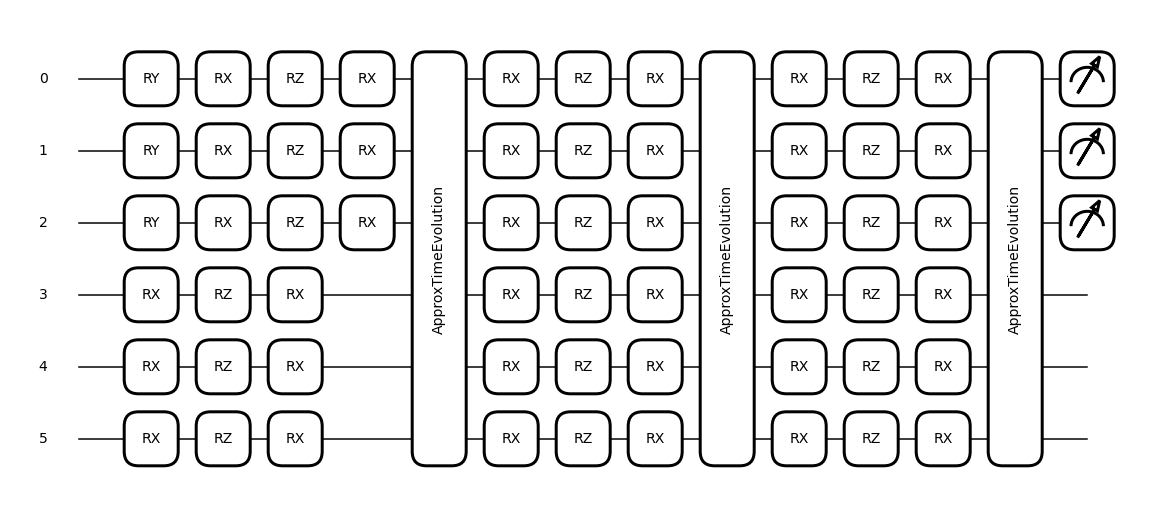

In [7]:
dev = qml.device("default.qubit", wires=6)
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 
# some fixed values (as specified in paper)
D = 3
tau = 0.2

# Parameters
# alpha_array = np.zeros((D, 6))
# beta_array  = np.zeros((D, 6))
# gamma_array = np.zeros((D, 6))
alpha_array = np.random.rand(D, 6)
beta_array  = np.random.rand(D, 6)
gamma_array = np.random.rand(D, 6)
c = np.asarray(1.0)

def encoding(x):
    qml.RY(np.arccos(x), wires=0)
    qml.RY(np.arccos(x), wires=1)
    qml.RY(np.arccos(x), wires=2)

def U1(alpha, beta, gamma, wire):
     qml.RX(alpha, wires=wire)
     qml.RZ(beta, wires=wire)
     qml.RX(gamma, wires=wire)

def evolution(alpha_array, beta_array, gamma_array):
    for i in range (D): # D = 3
        # U1 rotations
        for j in range(6):
            U1(alpha_array[i][j], beta_array[i][j], gamma_array[i][j], j)

        # np.exp(-1.0*j * Hint * tau) # e^(-i Hint tau)
        #change third paramter (larger is more accurate)
        qml.ApproxTimeEvolution(Hint, tau, 1)

@qml.qnode(dev)
def pqc(x, alpha_array, beta_array, gamma_array):
    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

#def timestep_output(x, weights):
def timestep_output(x, alpha_array, beta_array, gamma_array, c):
    
    # print(qml.draw_mpl(pqc)(0.5))
    #result = pqc(x, weights[0], weights[1], weights[2])
    result = pqc(x, alpha_array, beta_array, gamma_array)
    # print("Output of pqc: ", result)
    # print("Type of pqc: ", result[0])
    
    # y = c * np.average(result)
    y = c * (( result[0] + result[1] + result[2] ) / 3.0)
    # print("Output of each timestep: ", y)

    return y

timestep_output(0.7, alpha_array, beta_array, gamma_array, c)
# timestep_output(0.7, alpha_array, beta_array, gamma_array)
print(qml.draw_mpl(pqc)(0.5, alpha_array, beta_array, gamma_array))

# print(qml.draw_mpl(pqc)(0.5, 1))

### random code ideas, unused

# expval1 = qml.expval(qml.PauliZ(0))
# expval2 = qml.expval(qml.PauliZ(1))
# expval3 = qml.expval(qml.PauliZ(2))

# avg = (expval1 + expval2 + expval3) / 3.0

# print([expval1.eigvals(), expval2.eigvals(), expval3.eigvals()])

# return c * avg
# return expval1, expval2, expval3

In [11]:
timestep_output(0.7, alpha_array, beta_array, gamma_array, c)

tensor(0.36483646, requires_grad=True)

In [12]:
len(pqc.qtape.trainable_params)

99

[0.5, 0.45979899497487436, 0.41959798994974873, 0.37939698492462315, 0.33919597989949746, 0.2989949748743719, 0.25879396984924624, 0.2185929648241206, 0.17839195979899497, 0.13819095477386933, 0.0979899497487437, 0.05778894472361806, 0.017587939698492483, -0.022613065326633208, -0.06281407035175879, -0.10301507537688448, -0.14321608040201006, -0.18341708542713564, -0.22361809045226133, -0.2638190954773869, -0.3040201005025126, -0.3442211055276382, -0.3844221105527639, -0.42462311557788945, -0.46482412060301503, -0.4949748743718594, -0.4547738693467336, -0.414572864321608, -0.3743718592964824, -0.33417085427135684, -0.29396984924623104, -0.25376884422110546, -0.21356783919597988, -0.1733668341708543, -0.13316582914572872, -0.09296482412060292, -0.05276381909547734, -0.012562814070351758, 0.027638190954773822, 0.06783919597989962, 0.1080402010050252, 0.14824120603015079, 0.18844221105527637, 0.22864321608040195, 0.26884422110552775, 0.3090452261306533, 0.3492462311557789, 0.3894472361809

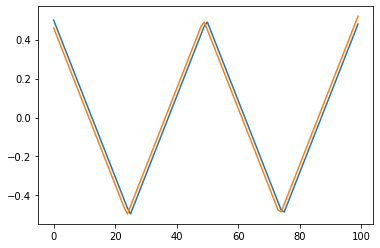

In [14]:
def generate_input(t_in):
    t = 8/199 * t_in
    if t >= 0 and t <= 1:
        return -t + 0.5
    elif t >= 1 and t <= 2:
        return t - 1.5
    elif t >= 2 and t <= 3:
        return -t + 2.5
    else:
        return t - 3.5

train_inputs = []
train_expected_outputs = []

for i in range(100):
    train_inputs.append(generate_input(i))
    train_expected_outputs.append(generate_input(i+1))

print(train_inputs)
print(train_expected_outputs)
plt.plot(train_inputs)
plt.plot(train_expected_outputs)

In [15]:
### Lecture 8 Demo helper functions

#def make_predictions(data, model, weights):
def make_predictions(data, model, alpha_array, beta_array, gamma_array, c):

    """Predict the labels of all points in a data set for a given model.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        model (qml.QNode): A QNode whose output expectation value will be
            used to make predictions of the labels of data.
        weights (array[float]): The trainable model parameters for the QNode. 
            
    Returns:
        array[int]: The array of predictions for each data point made by 
        the model QNode. 
    """
    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], alpha_array, beta_array, gamma_array, c)
        
        preds.append(estimated_expval)
            
    return preds

def make_loss_function(data, labels, model):

    #def loss(weights):
    def loss(alpha_array, beta_array, gamma_array, c):
        loss_sum = 0.0

        for idx in range(len(data)):
            point = data[idx]
            true_expval = labels[idx]

            #estimated_expval = model(point, weights)
            estimated_expval = model(point, alpha_array, beta_array, gamma_array, c)
            loss_sum += (estimated_expval - true_expval) ** 2

        return loss_sum / len(data)
    
    return loss

def compute_accuracy(predictions, true_labels):
    """Compute the accuracy of our predictions.
    
    Args:
        predictions (array[int]): Predicted values to 
        true_labels (array[int]): Integers identifying the class/label of 
            each data point.
    
    Returns:
        float: Accuracy of the predictions, returned as a percentage.
    """    
    n_samples = len(predictions)
    
    return np.sum(
        [np.abs(predictions[x]-true_labels[x]) < 0.1 for x in range(n_samples)
    ]) / n_samples

In [16]:
loss = make_loss_function(train_inputs, train_expected_outputs, timestep_output)

In [17]:
gradient_function = qml.grad(timestep_output)

In [18]:
# tune this parameter!
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

# weights = [alpha_array, beta_array, gamma_array, c]
# weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()

for it in range(n_its):
    # weights, _loss = opt.step_and_cost(loss, weights)
    # Add c as a trainable parameter
    (alpha_array, beta_array, gamma_array, c), _loss = opt.step_and_cost(loss, alpha_array, beta_array, gamma_array, c)

    if it % 5 == 0:
        #our_preds = make_predictions(train_inputs, timestep_output, weights)
        our_preds = make_predictions(train_inputs, timestep_output, alpha_array, beta_array, gamma_array, c)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, train_expected_outputs)}")
    loss_track.append(_loss)

Loss at iteration 0 = 0.19500227420141406  Accuracy = 0.2
Loss at iteration 5 = 0.1122947416423143  Accuracy = 0.24
Loss at iteration 10 = 0.07866033222254473  Accuracy = 0.24
Loss at iteration 15 = 0.06251906592742161  Accuracy = 0.24
Loss at iteration 20 = 0.053734452426754994  Accuracy = 0.25
Loss at iteration 25 = 0.0482830274468403  Accuracy = 0.27
Loss at iteration 30 = 0.04437178186232007  Accuracy = 0.28
Loss at iteration 35 = 0.04116514130676661  Accuracy = 0.28
Loss at iteration 40 = 0.03827476738774059  Accuracy = 0.3
Loss at iteration 45 = 0.03552654105226726  Accuracy = 0.31
Loss at iteration 50 = 0.03284849265528575  Accuracy = 0.33
Loss at iteration 55 = 0.030217020586549376  Accuracy = 0.36
Loss at iteration 60 = 0.027631759387514054  Accuracy = 0.36
Loss at iteration 65 = 0.025104090490275257  Accuracy = 0.36
Loss at iteration 70 = 0.022651707561776036  Accuracy = 0.39
Loss at iteration 75 = 0.02029556014539289  Accuracy = 0.41
Loss at iteration 80 = 0.0180575549995699

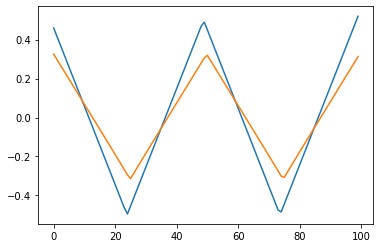

In [19]:
plt.plot(train_expected_outputs)
plt.plot(our_preds)

In [20]:
c

tensor(1.17114007, requires_grad=True)

In [21]:
# weights = np.random.normal(size=(2, 3), requires_grad=True)
weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()
weights

/usr/local/lib/python3.8/dist-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


[array([[ 0.41178884,  0.5958563 ,  0.4978084 ,  0.95499017,  0.4407473 ,
          0.15213097],
        [ 0.76784009, -0.03023417,  0.35731888,  0.10741632,  0.0116951 ,
          0.67423564],
        [ 0.42050698,  0.23530231, -0.08699741,  0.67229449,  0.49023873,
          0.14597524]]),
 array([[ 0.4800642 ,  0.66177368,  0.87491029,  0.84789145,  0.68531086,
          0.68512727],
        [-0.02699037, -0.0095773 ,  0.453432  ,  0.91873947,  0.14548134,
          0.0365374 ],
        [ 0.95470784,  0.81867226,  0.8009484 ,  0.64609938,  0.2926369 ,
          0.5567718 ]]),
 array([[ 0.35020162, -0.108386  , -0.078037  ,  0.73225459,  0.67633947,
          0.47326644],
        [ 0.35568067, -0.01779083,  0.3813282 ,  0.46952981,  0.69720987,
          0.48443231],
        [ 0.63631101,  0.41243615,  0.3195167 ,  0.56387231,  0.27771838,
          0.19713307]]),
 array(1.17114007)]